In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import time
import urllib.request
from tqdm import tqdm 
import time 
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
lemma = WordNetLemmatizer()
import re
from textblob import TextBlob

from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid =SentimentIntensityAnalyzer()

chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

#Function to scroll and get all the links to the articles




def get_links_to_articles(scrollNumber,searchTerm):

    driver = webdriver.Chrome('chromedriver',options=chrome_options)
    wait = WebDriverWait(driver, 2)
    driver.get("https://www.reuters.com/search/news?blob="+searchTerm)
    driver.find_element_by_xpath('//*[@id="content"]/section[2]/div/div[1]/div[4]/div/div[1]/div/div[1]/select/option[2]').click()


    




    for i in tqdm (range (scrollNumber),  
               desc="Scrolling..",  
               ascii=False):
        try:
            if driver.find_element_by_xpath('//*[@id="content"]/section[2]/div/div[1]/div[4]/div/div[4]/div[1]'):
                        wait.until(EC.visibility_of_element_located((By.XPATH, '//*[@id="content"]/section[2]/div/div[1]/div[4]/div/div[4]/div[1]')))
                        n = driver.find_element_by_xpath('//*[@id="content"]/section[2]/div/div[1]/div[4]/div/div[4]/div[1]')
                        driver.execute_script("arguments[0].click();", n)


            else:
                print('Not found')
        except:
            pass

            
            





    soup_a = BeautifulSoup(driver.page_source, 'lxml')
    html = driver.page_source
    driver.close()
    soup_a = BeautifulSoup(html, 'lxml')
    # Them we close the driver as soup_a is storing the page source

    # Empty array to store the links
    links = []
    article_urls = soup_a.findAll("h3",{"class":"search-result-title"})


    # Looping through all the a elements in the page source
    for link in article_urls:
        all_li = link.find_all('a')
        for li in all_li:
            links.append(li.get('href'))
            
    return links

         



In [2]:
def get_article(url):
    user_agent = 'Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US; rv:1.9.0.7) Gecko/2009021910 Firefox/3.0.7'
    headers={'User-Agent':user_agent,} 
    request=urllib.request.Request(url,None,headers)

    driver = webdriver.Chrome('chromedriver',options=chrome_options)
    wait = WebDriverWait(driver, 2)
    driver.get(url)

    article = driver.find_element_by_xpath('//*[@id="__next"]/div/div[4]/div[1]/article/div[1]').text
    

    t = driver.find_elements_by_css_selector('time')
    
    time = []

    for i in t:
        time.append(i.text)

    driver.close()



    return time,article

    
def get_all_articles(list_urls):
    print("\n Getting all articles from links")
    print(" *This will take some time please be patient*")
    articles = []
    time = []
    base = 'https://www.reuters.com'
    

    for link in tqdm(list_urls):
        u = base+link
        t,a = get_article(u)
        time.append(t)
        articles.append(a)

       
        
      
    return time,articles 



def prepare_dt(t):  
  l =[]
  for i in t:
    try:
      i.remove(i[2])
      l.append(i)
    except:
      l.append(i)
  tii = []
  for i in l:
      separator = ', '
      tii.append(separator.join(i))
  return tii




def make_df(time,articles):
    time = prepare_dt(time)
    df = pd.DataFrame({'Datetime':time,'Article':articles})
    return df

def clean_text(text):
     totalStopwords = set([word.replace("'",'') for word in stopwords.words('english')])
     text = text.lower()
     text = text.replace("'",'')
     text = re.sub('[^a-zA-Z]',' ',text)
     words = text.split()
     words = [lemma.lemmatize(word) for word in words if (word not in totalStopwords) and (len(word)>1)] # Remove stop words
     text = " ".join(words)

     return text





def cleaning_sentiment_scoring(df):
    print("\n Cleaning Text")
    df['Article'] = df['Article'].apply(lambda x:clean_text(x))
    df['Datetime'] = pd.to_datetime(df.Datetime)
    print("\n Analyzing Sentiment")
    
    new_words = {
        'fall':-2.0,
        'edge':1,
        'rise':2.0,
        'slip':-2.0,
        'drop':-2.0,
        'gain':2.0,
        'jump':2.0,
        'climb':2.0,
        'rally':2.0,
        'hit':-1,
        'end':0.4
        
    }


    sid.lexicon.update(new_words)
    
    desc_blob = [TextBlob(desc) for desc in df['Article']]
    #add the sentiment metrics to the dataframe
    df['Polarity'] = [b.sentiment.polarity for b in desc_blob]
    df['Subjectivity'] = [b.sentiment.subjectivity for b in desc_blob]
    #load VADER
    analyzer = SentimentIntensityAnalyzer()
    #Add VADER metrics to dataframe
    df['compound'] = [sid.polarity_scores(v)['compound'] for v in df['Article']]
    df['neg'] = [sid.polarity_scores(v)['neg'] for v in df['Article']]
    df['neu'] = [sid.polarity_scores(v)['neu'] for v in df['Article']]
    df['pos'] = [sid.polarity_scores(v)['pos'] for v in df['Article']]
    return df

In [3]:
def show_sentiment_by_hr(df):
    ndf = df.set_index('Datetime').resample('H')['compound'].mean().dropna().plot(color='r', label='Sentiment')
    ndf.legend(loc="upper right")
    ndf.set_xlabel('Datetime')
    ndf.set_ylabel('Sentiment')
    ndf.yaxis.label.set_color('blue')
    ndf.xaxis.label.set_color('blue')

    


def show_sentiment_by_day(df):    
    ndf = df.set_index('Datetime').resample('D')['compound'].mean().fillna(df['compound'].mean()).plot(color='r', label='Sentiment')
    ndf.legend(loc="upper right")
    ndf.set_xlabel('Datetime')
    ndf.set_ylabel('Sentiment')
    ndf.yaxis.label.set_color('blue')
    ndf.xaxis.label.set_color('blue')


    
def show_sentiment_by_week(df):    
    ndf = df.set_index('Datetime').resample('W')['compound'].mean().fillna(df['compound'].mean()).plot(color='r', label='Sentiment')
    ndf.legend(loc="upper right")
    ndf.set_xlabel('Datetime')
    ndf.set_ylabel('Sentiment')
    ndf.yaxis.label.set_color('blue')
    ndf.xaxis.label.set_color('blue')

    
    
    
    
    
def save_to_excel(df,name):
    df.to_excel('reutersnews/'+name+'NewsSentiment.xlsx')
    print('File saved as: ', name+'NewsSentiment.xlsx')

In [4]:
def search():
    link = input('Please enter name for example: Apple:aaple :')
    scroll = int(input('Please enter pages to scroll :'))
    l =get_links_to_articles(scroll,link)
    t,a  =get_all_articles(l)
    df = make_df(t,a)
    df = cleaning_sentiment_scoring(df)

    save_to_excel(df,link)
    print('\n **Done**')
    return df

In [5]:
df = search()

Please enter name for example: Apple:aaple :aaple
Please enter pages to scroll :1


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]


 Getting all articles from links
 *This will take some time please be patient*


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:14<00:00,  7.43s/it]



 Cleaning Text

 Analyzing Sentiment
File saved as:  aapleNewsSentiment.xlsx

 **Done**


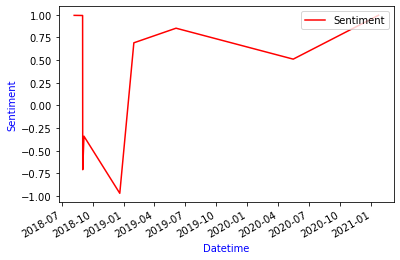

In [6]:
#Horly sentiment
show_sentiment_by_hr(df)

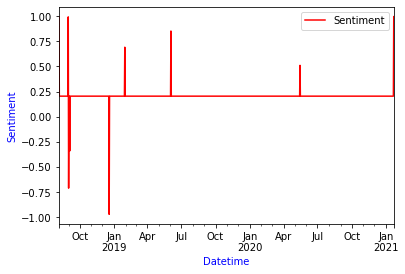

In [7]:
#Daily sentiment
show_sentiment_by_day(df)


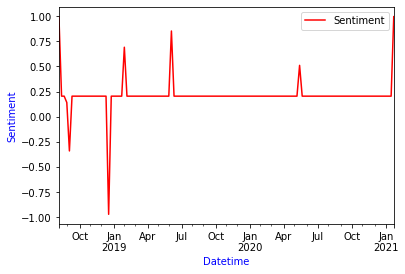

In [8]:
#weekly sentiment
show_sentiment_by_week(df)